
<a id='aiyagari'></a>

# The Aiyagari Model

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
#!pip install quantecon

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import jax
import jax.numpy as jnp

In [3]:
# Use 64 bit floats with JAX in order to match NumPy/Numba code
jax.config.update("jax_enable_x64", True)

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bew77](https://python.quantecon.org/zreferences.html#id173)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiy94](https://python.quantecon.org/zreferences.html#id137)].

The model features

- Heterogeneous agents  
- A single exogenous vehicle for borrowing and lending  
- Limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94](https://python.quantecon.org/zreferences.html#id137)]  
- risk sharing and asset pricing [[HL96](https://python.quantecon.org/zreferences.html#id129)]  
- the shape of the wealth distribution [[BBZ15](https://python.quantecon.org/zreferences.html#id130)]  


### References

The primary reference for this lecture is [[Aiy94](https://python.quantecon.org/zreferences.html#id137)].

A textbook treatment is available in chapter 18 of [[LS18](https://python.quantecon.org/zreferences.html#id182)].

A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb).

## The Economy

### Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

The wage and interest rate are fixed over time.

In this simple version of the model, households supply labor  inelastically because they do not value leisure.

## Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K_t $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{70.1}
$$

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{70.2}
$$

### Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE).

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  


In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick a proposed quantity $ K $ for aggregate capital  
1. determine corresponding prices, with interest rate $ r $ determined by [(70.1)](#equation-aiy-rgk) and a wage rate $ w(r) $ as given in [(70.2)](#equation-aiy-wgr)  
1. determine the common optimal savings policy of the households given these prices  
1. compute aggregate capital as the mean of steady state capital given this savings policy  


If this final quantity agrees with $ K $ then we have a SREE.

## Primitives and Opertors


This class stores the parameters that define a household asset 
accumulation problem and the grids used to solve it.

In [23]:
class Household:

    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_grid=[0.1, 1.0],           # Exogenous states
                a_min=1e-10, a_max=18,       # Asset grid
                a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_size = a_size
        self.a_grid = jnp.linspace(a_min, a_max, a_size)
        z_grid, Π = map(np.array, (z_grid, Π))
        self.Π = jax.device_put(Π)
        self.z_grid = jax.device_put(z_grid)
        self.z_size = len(z_grid)
        
    def constants(self):
        return self.r, self.w, self.β
    
    def sizes(self):
        return self.a_size, self.z_size
    
    def arrays(self):
        return self.a_grid, self.z_grid, self.Π

This is the right-hand side of the Bellman equation for the household:

In [26]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation 
    (before maximization), which is a 3D array representing

        B(a, z, a') = u(wz + (1+r)a - a') + β Σ_z' v(a', z') Π(z, z')

    for all (a, z, a').
    """

    # Unpack 
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w*z + (1 + r)*a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, jnp.log(c) + β * EV, -jnp.inf)

The next function computes greedy policies.

In [27]:
def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

We need to know rewards at a given policy for policy iteration.

In [48]:
def compute_r_σ(σ, constants, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r)*a + w*z - ap
    r_σ = jnp.log(c)

    return r_σ

The following linear operator is also needed for policy iteration.

In [49]:
def R_σ(v, σ, constants, sizes, arrays):
    """
    The value v_σ of a policy σ is defined as 

        v_σ = (I - β P_σ)^{-1} r_σ

    Here we set up the linear map v -> R_σ v, where R_σ := I - β P_σ. 

    In the consumption problem, this map can be expressed as

        (R_σ v)(a, z) = v(a, z) - β Σ_z' v(σ(a, z), z') Π(z, z')

    Defining the map as above works in a more intuitive multi-index setting
    (e.g. working with v[i, j] rather than flattening v to a one-dimensional
    array) and avoids instantiating the large matrix P_σ.

    """
    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=2)

The next function computes the lifetime value of a given policy.

In [50]:
def get_value(σ, constants, sizes, arrays):
    "Get the value v_σ of policy σ by inverting the linear map R_σ."

    r_σ = compute_r_σ(σ, constants, sizes, arrays)
    # Reduce R_σ to a function in v
    partial_R_σ = lambda v: R_σ(v, σ, constants, sizes, arrays)
    # Compute inverse v_σ = (I - β P_σ)^{-1} r_σ
    return jax.scipy.sparse.linalg.bicgstab(partial_R_σ, r_σ)[0]

Let's target these functions for JIT-compilation.

In [51]:
B = jax.jit(B, static_argnums=(2,))
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))
get_value = jax.jit(get_value, static_argnums=(2,))
R_σ = jax.jit(R_σ, static_argnums=(3,))

## Solvers

We will solve the household problem using Howard policy iteration.

In [52]:
def policy_iteration(model, verbose=True):
    "Howard policy iteration routine."
    constants = model.constants()
    sizes = model.sizes()
    arrays = model.arrays()
    
    vz = jnp.zeros(sizes)
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, constants, sizes, arrays)
        σ_new = get_greedy(v_σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    return σ

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices.

In [53]:
# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
model = Household(a_max=20, r=r, w=w)

In [54]:
σ_star = policy_iteration(model)

Concluded loop 1 with error 101.
Concluded loop 2 with error 76.
Concluded loop 3 with error 36.
Concluded loop 4 with error 17.
Concluded loop 5 with error 12.
Concluded loop 6 with error 6.
Concluded loop 7 with error 3.
Concluded loop 8 with error 2.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 0.


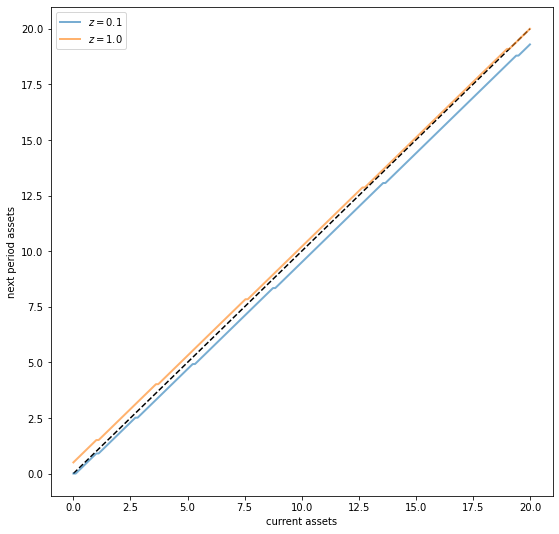

In [55]:
a_size, z_size = model.sizes()
a_grid, z_grid, Π = model.arrays()

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_grid, a_grid, 'k--')  # 45 degrees
for j in range(z_size):
    lb = f'$z = {z_grid[j]:.2}$'
    ax.plot(a_grid, a_grid[σ_star[:, j]], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

In [58]:
@jax.jit
def compute_stationary(P):
    "Compute the stationary distribution of P by matrix inversion."
    n = len(P)
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))


In [59]:
def compute_asset_stationary(σ, constants, sizes, arrays):
    """
    Compute the stationary distribution of assets under the policy σ.
    
    """
    
    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays
    
    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π
    
    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))
    
    # Get stationary distribution and reshape onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))
    
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

In [61]:
compute_asset_stationary = jax.jit(compute_asset_stationary, 
                                  static_argnums=(2,))

In [62]:
constants = model.constants()
sizes = model.sizes()
arrays = model.arrays()
ψ = compute_asset_stationary(σ_star, constants, sizes, arrays)

In [63]:
ψ.sum()

DeviceArray(1., dtype=float64)

The plot shows asset accumulation policies at different values of the exogenous state.

In [64]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(model, r):
    """
    Map interest rate to the induced level of capital stock.
    """
    w = r_to_w(r)
    model.r, model.w = r, w
    constants = model.constants()
    sizes = model.sizes()
    arrays = model.arrays()
    
    # Compute the optimal policy
    σ_star = policy_iteration(model, verbose=False)
    # Compute the stationary distribution
    ψ_a = compute_asset_stationary(σ_star, constants, sizes, arrays)
    # Return K
    return float(jnp.sum(ψ_a * model.a_grid))

Now we want to calculate the equilibrium.

Let’s do this visually as a first pass.

The following code draws aggregate supply and demand curves.

The intersection gives equilibrium interest rates and capital.

In [65]:
# Create an instance of Household
model = Household(a_max=20)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

In [68]:
%%time
# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(model, r)

CPU times: user 1.01 s, sys: 100 ms, total: 1.11 s
Wall time: 907 ms


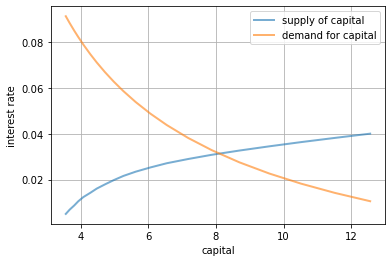

In [69]:
# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()